In [1]:
# load the modules 

import functions.plot_params
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr

from cartopy.util import add_cyclic_point

import cartopy
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import cmocean.cm as cmo
from tqdm.notebook import tqdm

from functions.map_plotting import southern_ocean_map
import matplotlib.ticker as mticker

plt.rc('ytick.major', size=5)
plt.rc('xtick.major', size=5)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# load the ACC fronts and sea ice edge locations 

import pandas as pd

sie = pd.read_csv('../../data/seaice/sie.csv').to_xarray().drop('Unnamed: 0')
fronts = pd.read_csv('../../data/fronts/ACCfronts.csv').to_xarray().drop('Unnamed: 0')

In [3]:
# read in the cyclone data

cyclones = xr.open_mfdataset('/Users/xduplm/Google Drive/My Drive/data/storms_lodise/ec_centers_1981_2020.nc')

ds_cyclones_summer = cyclones.sel(TIME=cyclones.TIME.dt.season=="DJF")

In [4]:
# find the meridional direction of the cyclones

eqwrd_lat = []
eqwrd_lon = []
plwrd_lat = []
plwrd_lon = []

for i, id in tqdm(enumerate(np.unique(ds_cyclones_summer.STORM_ID))):

    ds = ds_cyclones_summer.isel(TIME=ds_cyclones_summer.STORM_ID.values==id)

    if ds.LATITUDE[0] < ds.LATITUDE[-1]: # if the end latitudes is larger than the start, it's a northward moving storm
        eqwrd_lon += ds.LONGITUDE.values.tolist()
        eqwrd_lat += ds.LATITUDE.values.tolist()

    if ds.LATITUDE[0] > ds.LATITUDE[-1]: # if the end latitudes is less than the start, it's a southward moving storm
        plwrd_lon += ds.LONGITUDE.values.tolist()
        plwrd_lat += ds.LATITUDE.values.tolist()

eqwrd_lat = np.array(eqwrd_lat)
eqwrd_lon = np.array(eqwrd_lon)
plwrd_lat = np.array(plwrd_lat)
plwrd_lon = np.array(plwrd_lon)


0it [00:00, ?it/s]

In [5]:
# what is the proportion of poleward moving cyclones?

1-eqwrd_lat.size/plwrd_lat.size

0.7723654978455979

In [6]:
# histogram of the poleward and equatorward moving cyclone

eqwrd_hist, x_hist, y_hist, img1 = plt.hist2d(eqwrd_lon, eqwrd_lat, bins=(360, 50), cmap='Purples')
plwrd_hist, x_hist, y_hist, img2 = plt.hist2d(plwrd_lon, plwrd_lat, bins=(360, 50), cmap='Oranges')

plt.close()

In [ ]:
# figure 4a, b

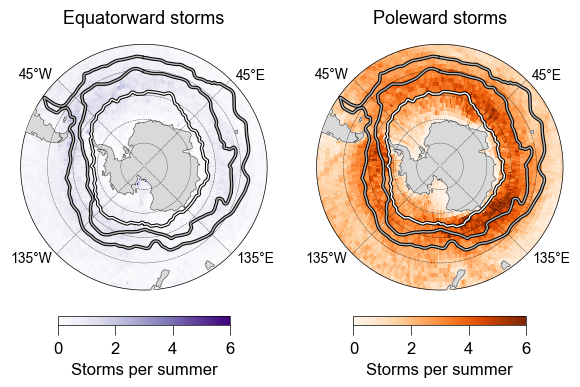

In [9]:
# distribution maps of the northbound and southbound cyclones

fig = plt.figure(figsize=(7, 4.5))

ax0 = fig.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax1 = fig.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())

ax0 = southern_ocean_map(ax0)
ax1 = southern_ocean_map(ax1)

img0 = ax0.pcolormesh(x_hist[1:], y_hist[1:], (eqwrd_hist/40).T, cmap='Purples', vmin=0, vmax=6, transform=ccrs.PlateCarree())
img1 = ax1.pcolormesh(x_hist[1:], y_hist[1:], (plwrd_hist/40).T, cmap='Oranges', vmin=0, vmax=6, transform=ccrs.PlateCarree())

cb0 = plt.colorbar(img0, ax=ax0, shrink=0.7, pad=0.075, orientation='horizontal')
cb1 = plt.colorbar(img1, ax=ax1, shrink=0.7, pad=0.075, orientation='horizontal')

cb0.set_label('Storms per summer')
cb1.set_label('Storms per summer')

props = dict(pad=15, fontsize=13)

ax0.set_title('Equatorward storms', **props)
ax1.set_title('Poleward storms', **props)

for a in [ax0, ax1]:    

    # plot the fronts and grid    

    gl = a.gridlines(ls='--', color='k', lw=0.25, zorder=100)
    gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines    

    # plot the fronts     

    a.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
    a.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)    

    a.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
    a.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)    

    # plot the sea ice     

    a.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
    a.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)
    

plt.savefig('../../figs/figure-4ab.png', dpi=300, transparent=True)

In [ ]:
# figure 4c

0it [00:00, ?it/s]

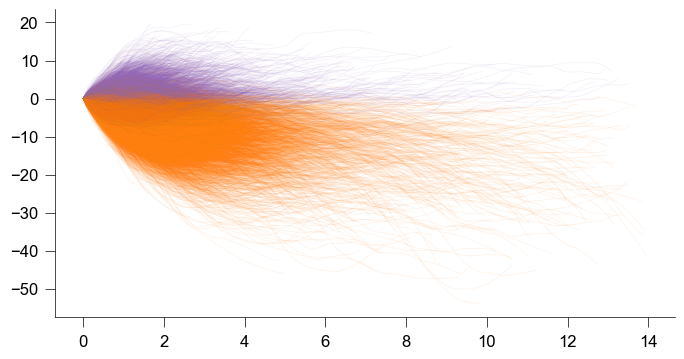

In [11]:
# Plot a hovmoller plot of the storm tracks that are obtainable from the Lodise dataset

from scipy.interpolate import griddata

cyclone_time = np.arange(0, 14 + 0.25, 0.25)

cyclones_south = np.array(np.zeros(cyclone_time.size))
cyclones_north = np.array(np.zeros(cyclone_time.size))

fig,ax = plt.subplots(figsize=(8, 4))

for i, id in tqdm(enumerate(np.unique(ds_cyclones_summer.STORM_ID))):

    ds = ds_cyclones_summer.isel(TIME=ds_cyclones_summer.STORM_ID.values==id)

    time = (ds.TIME.data.astype('float') - ds.TIME[0].data.astype('float'))/1e9/60/60/24

    if ds.LATITUDE[0] < ds.LATITUDE[-1]: # if the end latitudes is larger than the start, it's a northward moving storm
        ax.plot(time, ds.LATITUDE - ds.LATITUDE[0], lw=0.5, alpha=0.1, c='tab:purple')

        cyc_track = griddata(time, ds.LATITUDE - ds.LATITUDE[0], cyclone_time)
        cyclones_north = np.vstack((cyclones_north, cyc_track))
    

    if ds.LATITUDE[0] > ds.LATITUDE[-1]: # if the end latitudes is less than the start, it's a southward moving storm
        ax.plot(time, ds.LATITUDE - ds.LATITUDE[0], lw=0.5, alpha=0.1, c='tab:orange')

        cyc_track = griddata(time, ds.LATITUDE - ds.LATITUDE[0], cyclone_time)
        cyclones_south = np.vstack((cyclones_south, cyc_track))        

cyclones_north = cyclones_north[1:]
cyclones_south = cyclones_south[1:]        

# determine distance from latitude

import gsw

gsw.distance([0, 0], [0, 1])/1000

cyclones_south = cyclones_south * 0.11119492664
cyclones_north = cyclones_north * 0.11119492664

/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_15739/2669625970.py:4: RuntimeWarning: Mean of empty slice
  mean_north = np.nanmean(cyclones_north, axis=0)
/Users/xduplm/opt/anaconda3/envs/storms_env/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/var/folders/v4/3lf8sz_n06jf5z94ng5n_mnh0000gp/T/ipykernel_15739/2669625970.py:10: RuntimeWarning: Mean of empty slice
  mean_south = np.nanmean(cyclones_south, axis=0)


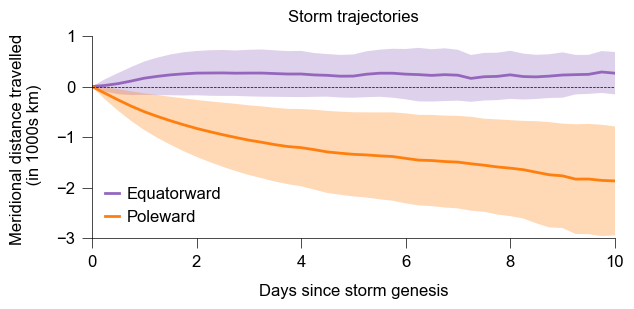

In [24]:
# plot the mean merdional movement of the poleward and equatorward cyclones
fig,ax = plt.subplots(figsize=(6.5, 3.25))

mean_north = np.nanmean(cyclones_north, axis=0)
std_north = np.nanstd(cyclones_north, axis=0)

ax.plot(cyclone_time, mean_north, c='tab:purple', lw=2, label='Equatorward')
ax.fill_between(cyclone_time, mean_north + std_north, mean_north - std_north, facecolor='tab:purple', alpha=0.3)

mean_south = np.nanmean(cyclones_south, axis=0)
std_south = np.nanstd(cyclones_south, axis=0)

ax.plot(cyclone_time, mean_south, c='tab:orange', lw=2, label='Poleward')
ax.fill_between(cyclone_time, mean_south + std_south, mean_south - std_south, facecolor='tab:orange', alpha=0.3)

ax.legend(fontsize=12, ncol=1, frameon=False, loc='lower left', bbox_to_anchor=(0, 0), handlelength=0.8, handletextpad=0.5, borderpad=0.3)

ax.set_ylim(-3, 1)
ax.set_xlim(0, 10)

ax.yaxis.set_ticks(np.arange(-3, 2, 1))

ax.set_xlabel('Days since storm genesis', labelpad=10)
# ax.set_title('Meridional distance travelled by storms', pad=15)

ax.set_ylabel('Meridional distance travelled \n (in 1000s km)', labelpad=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.axhline(lw=0.5, ls='--', c='k')

ax.set_title('Storm trajectories', fontsize=12, pad=10)

fig.tight_layout()

plt.savefig('../../figs/figure-4c.png', dpi=500)

In [25]:
# read in the storm and interstorm statistics

ds_storms = xr.open_dataset('/Volumes/LaCie/Work/data/era5/era5_storm_interstorm_periods_1981_2023_DJF.nc')

In [27]:
# load interannual flux statistics data

ds_mean = xr.open_dataset('../../data/era5/mean_summer_winds_fluxes_1981_2023.nc')

In [ ]:
# figure 4d, e

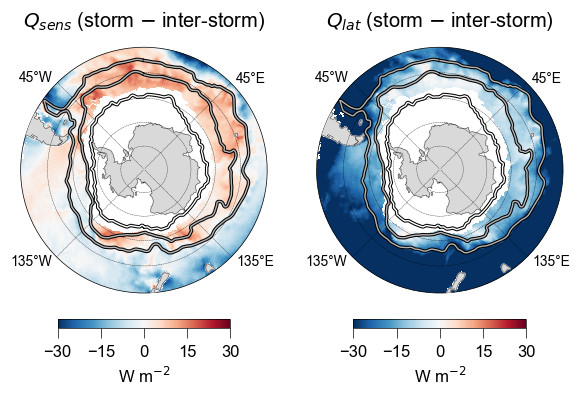

In [42]:
fig = plt.figure(figsize=(7, 4.5))

ax0 = fig.add_subplot(1, 2, 1, projection=ccrs.SouthPolarStereo())
ax1 = fig.add_subplot(1, 2, 2, projection=ccrs.SouthPolarStereo())

img0 = ds_storms.diff_shf.mean(dim='time', skipna=False).plot(ax=ax0, transform=ccrs.PlateCarree(), vmin=-30, vmax=30, cmap='RdBu_r', add_colorbar=False)
img1 = ds_storms.diff_lhf.mean(dim='time', skipna=False).plot(ax=ax1, transform=ccrs.PlateCarree(), vmin=-30, vmax=30, cmap='RdBu_r', add_colorbar=False)

ax0 = southern_ocean_map(ax0)
ax1 = southern_ocean_map(ax1)

cb0 = plt.colorbar(img0, ax=ax0, shrink=0.7, pad=0.075, orientation='horizontal')
cb1 = plt.colorbar(img1, ax=ax1, shrink=0.7, pad=0.075, orientation='horizontal')

cb0.set_ticks([-30, -15, 0, 15, 30])
cb1.set_ticks([-30, -15, 0, 15, 30])

cb0.set_label('W m$^{-2}$')
cb1.set_label('W m$^{-2}$')

ax0.set_title('$Q_{sens}$ (storm $\minus$ inter-storm)', pad=15)
ax1.set_title('$Q_{lat}$ (storm $\minus$ inter-storm)', pad=15)

ax0.add_feature(cfeature.OCEAN, facecolor='w')
ax1.add_feature(cfeature.OCEAN, facecolor='w')

for a in [ax0, ax1]:

    # plot the fronts and grid

    gl = a.gridlines(ls='--', color='k', lw=0.25, zorder=100)
    gl.xlocator = mticker.FixedLocator([-135, -45, 45, 135])  # Specify the longitudes for the gridlines
    
    # plot the fronts 
    
    a.plot(fronts['saf_lon'], fronts['saf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
    a.plot(fronts['saf_lon'], fronts['saf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)    

    a.plot(fronts['pf_lon'], fronts['pf_lat'], lw=2.5, c='k', transform=ccrs.PlateCarree(), zorder=110)
    a.plot(fronts['pf_lon'], fronts['pf_lat'], lw=1, c='0.7', transform=ccrs.PlateCarree(), zorder=110)    

    # plot the sea ice     

    a.plot(sie['si_lon'], sie['si_lat'], c='k', lw=2.5, transform=ccrs.PlateCarree(), zorder=110)
    a.plot(sie['si_lon'], sie['si_lat'], c='w', lw=1, transform=ccrs.PlateCarree(), zorder=110)
    
plt.savefig('../../figs/figure-4de.png', dpi=300)



In [28]:
# functions calculating stats comparing storms days to flux anomalies

from scipy.stats import linregress

def interannual_stats(ds, dep_var, ind_var):

    # define storm days climatology
    clim = ds[dep_var].mean(dim=('time'))

    # define seasonal anomaly
    anom = ds[dep_var] - clim

    # southern ocean mean anomaly
    so_anom_mean = anom.mean(dim=('latitude', 'longitude'))

    slope, intercept, r_value, p_value, std_err = linregress(so_anom_mean, ind_var)

    return slope, intercept, r_value, p_value, std_err, so_anom_mean

In [29]:
# function to determine confidence interval statistics

import scipy.stats as stats

def calc_ci_stats(data, ci=0.99):

    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)
    n = len(data)
    sem = std_dev / np.sqrt(n)
    
    df = n - 1
    t_value = stats.t.ppf(ci, df)
    
    margin_of_error = t_value * sem
    
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error

    return lower_bound, upper_bound

In [30]:
# find the yerr for the total storm days

yerr_tsd = np.ndarray([ds_storms.time.size])

for time_index in range(ds_storms.time.size):

    # Select the data for the specified time index
    data_at_time = ds_storms.isel(time=time_index)

    # Stack the longitude and latitude dimensions
    stacked_data = data_at_time.storm_period_total_days.stack(z=('longitude', 'latitude'))

    # Find instances where numbers exist
    data = stacked_data.where(~stacked_data.isnull(), drop=True).data

    lower_bound, upper_bound = calc_ci_stats(data)

    yerr_tsd[time_index] = (upper_bound - lower_bound)

In [31]:
# calculate the confidence interval for sensible and latent heat fluxes

import numpy as np
import scipy.stats as stats

yerr_shf = np.ndarray([ds_mean.time.size])
yerr_lhf = np.ndarray([ds_mean.time.size])

for time_index in range(ds_mean.time.size):

    # Select the data for the specified time index
    data_at_time = ds_mean.isel(time=time_index)

    # Stack the longitude and latitude dimensions
    stacked_data_shf = data_at_time.sshf.stack(z=('longitude', 'latitude'))
    stacked_data_lhf = data_at_time.slhf.stack(z=('longitude', 'latitude'))

    # Find instances where numbers exist
    data_shf = stacked_data_shf.where(~stacked_data_shf.isnull(), drop=True).data
    data_lhf = stacked_data_lhf.where(~stacked_data_lhf.isnull(), drop=True).data

    lower_bound_shf, upper_bound_shf = calc_ci_stats(data_shf)
    lower_bound_lhf, upper_bound_lhf = calc_ci_stats(data_lhf)

    yerr_shf[time_index] = (upper_bound_shf - lower_bound_shf)
    yerr_lhf[time_index] = (upper_bound_lhf - lower_bound_lhf)

In [ ]:
# figure 4f, g

In [35]:
# calculate flux anomalies

shf_flux_clim = ds_mean['sshf'].mean(dim=('time'))
    
shf_flux_anom_so_mean = (ds_mean['sshf'] - shf_flux_clim).mean(dim=('latitude', 'longitude'))
shf_flux_anom_so_std  = (ds_mean['sshf'] - shf_flux_clim).std(dim=('latitude', 'longitude'))

lhf_flux_clim = ds_mean['slhf'].mean(dim=('time'))
    
lhf_flux_anom_so_mean = (ds_mean['slhf'] - lhf_flux_clim).mean(dim=('latitude', 'longitude'))
lhf_flux_anom_so_std  = (ds_mean['slhf'] - lhf_flux_clim).std(dim=('latitude', 'longitude'))

ssr_flux_clim = ds_mean['ssr'].mean(dim=('time'))
    
ssr_flux_anom_so_mean = (ds_mean['ssr'] - ssr_flux_clim).mean(dim=('latitude', 'longitude'))
ssr_flux_anom_so_std  = (ds_mean['ssr'] - ssr_flux_clim).std(dim=('latitude', 'longitude'))

str_flux_clim = ds_mean['str'].mean(dim=('time'))
    
str_flux_anom_so_mean = (ds_mean['str'] - str_flux_clim).mean(dim=('latitude', 'longitude'))
str_flux_anom_so_std  = (ds_mean['str'] - str_flux_clim).std(dim=('latitude', 'longitude'))

net_flux_clim = ds_mean['qnet'].mean(dim=('time'))
    
net_flux_anom_so_mean = (ds_mean['qnet'] - net_flux_clim).mean(dim=('latitude', 'longitude'))
net_flux_anom_so_std  = (ds_mean['qnet'] - net_flux_clim).std(dim=('latitude', 'longitude'))

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
0.1987680224003915 -0.0008808616203089905 0.684383131576087 5.805691593209419e-07 0.03348249166804967
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


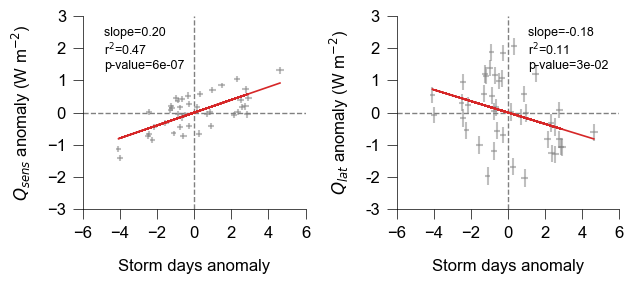

In [36]:
fig = plt.figure(figsize=[6.5, 3])

ax0 = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

var = ['sshf', 'slhf']

for i, v in enumerate(var):

    flux_clim = ds_mean[v].mean(dim=('time'))
    
    flux_so_mean = (ds_mean[v] - flux_clim).mean(dim=('latitude', 'longitude'))
    flux_so_std = (ds_mean[v] - flux_clim).std(dim=('latitude', 'longitude'))

    # Perform linear regression for dataset 1
    

    if i==0:
        slope, intercept, r_value, p_value, std_err, so_storm_days_anom_mean = interannual_stats(ds=ds_storms, dep_var='storm_period_total_days', ind_var=shf_flux_anom_so_mean)
        fit = slope * so_storm_days_anom_mean + intercept
        
        ax0.errorbar(x=so_storm_days_anom_mean, y=flux_so_mean, yerr=yerr_shf, xerr=yerr_tsd, fmt='o', markersize=0, capsize=0, lw=1.5, color='0.5', alpha=0.5)
        ax0.plot(so_storm_days_anom_mean, fit, color='tab:red', label= f'slope={slope:.2f} \nr$^{2}$={r_value**2:.2f} \np-value={p_value:.0e}')

        print(slope, intercept, r_value, p_value, std_err)

    elif i==1:
        slope, intercept, r_value, p_value, std_err, so_storm_days_anom_mean = interannual_stats(ds=ds_storms, dep_var='storm_period_total_days', ind_var=lhf_flux_anom_so_mean)
        fit = slope * so_storm_days_anom_mean + intercept

        ax1.errorbar(x=so_storm_days_anom_mean, y=flux_so_mean, yerr=yerr_lhf, xerr=yerr_tsd, fmt='o', markersize=0, capsize=0, lw=1.5, color='0.5', alpha=0.5)
        ax1.plot(so_storm_days_anom_mean, fit, color='tab:red', label= f'slope={slope:.2f} \nr$^{2}$={r_value**2:.2f} \np-value={p_value:.0e}')

ax0.legend(fontsize=9, loc=2, handlelength=0, frameon=False)
ax1.legend(fontsize=9, loc=1, handlelength=0, frameon=False)

for a in [ax0, ax1]:

    a.set_xlim(-5, 5)
    a.set_ylim(-3, 3)

    a.axhline(ls='--', c='0.5', zorder=0, lw=1)
    a.axvline(ls='--', c='0.5', zorder=0, lw=1)

    a.set_xlabel('Storm days anomaly', labelpad=13, fontsize=12)

ax0.yaxis.set_ticks(np.arange(-3, 4, 1))
ax1.yaxis.set_ticks(np.arange(-3, 4, 1))

ax0.xaxis.set_ticks(np.arange(-6, 8, 2))
ax1.xaxis.set_ticks(np.arange(-6, 8, 2))

ax1.yaxis.set_ticklabels(np.arange(-3, 4, 1), c='k')

props = dict(fontsize=12, labelpad=10)

ax0.set_ylabel('$Q_{sens}$ anomaly (W m$^{-2}$)', **props)
ax1.set_ylabel('$Q_{lat}$ anomaly (W m$^{-2}$)', **props)

fig.tight_layout()

plt.savefig('../../figs/figure-4fg.png', dpi=300)


In [ ]:
# extended data figure 4a

In [38]:
# calculate the confidence interval for shortwave and longwave heat fluxes

yerr_ssr = np.ndarray([ds_mean.time.size])
yerr_str = np.ndarray([ds_mean.time.size])
yerr_net = np.ndarray([ds_mean.time.size])

for time_index in range(ds_mean.time.size):

    # Select the data for the specified time index
    data_at_time = ds_mean.isel(time=time_index)

    # Stack the longitude and latitude dimensions
    stacked_data_ssr = data_at_time.ssr.stack(z=('longitude', 'latitude'))
    stacked_data_str = data_at_time.str.stack(z=('longitude', 'latitude'))
    stacked_data_net = data_at_time.qnet.stack(z=('longitude', 'latitude'))

    # Find instances where numbers exist
    data_ssr = stacked_data_ssr.where(~stacked_data_ssr.isnull(), drop=True).data
    data_str = stacked_data_str.where(~stacked_data_str.isnull(), drop=True).data
    data_net = stacked_data_str.where(~stacked_data_str.isnull(), drop=True).data

    lower_bound_ssr, upper_bound_ssr = calc_ci_stats(data_ssr)
    lower_bound_str, upper_bound_str = calc_ci_stats(data_str)
    lower_bound_net, upper_bound_net = calc_ci_stats(data_net)

    yerr_ssr[time_index] = (upper_bound_ssr - lower_bound_ssr)
    yerr_str[time_index] = (upper_bound_str - lower_bound_str)
    yerr_net[time_index] = (upper_bound_net - lower_bound_net)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


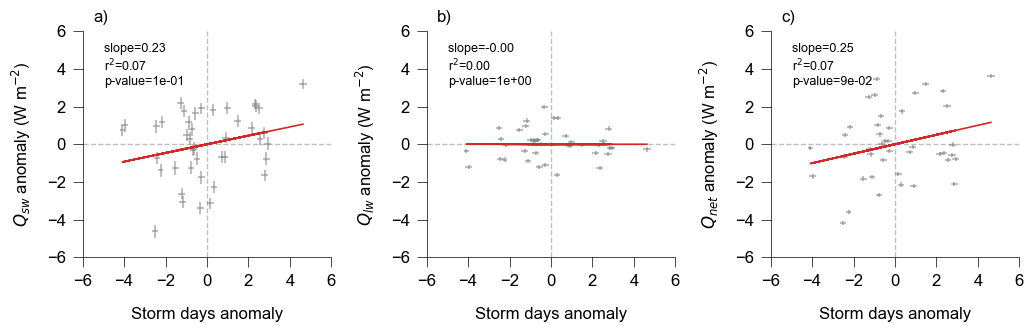

In [40]:
fig = plt.figure(figsize=[10.5, 3.5])

ax0 = fig.add_subplot(1, 3, 1)
ax1 = fig.add_subplot(1, 3, 2)
ax2 = fig.add_subplot(1, 3, 3)

var = ['ssr', 'str', 'qnet']

for i, v in enumerate(var):

    flux_clim = ds_mean[v].mean(dim=('time'))
    
    flux_so_mean = (ds_mean[v] - flux_clim).mean(dim=('latitude', 'longitude'))
    flux_so_std = (ds_mean[v] - flux_clim).std(dim=('latitude', 'longitude'))

    if i==0:
        slope, intercept, r_value, p_value, std_err, so_storm_days_anom_mean = interannual_stats(ds=ds_storms, dep_var='storm_period_total_days', ind_var=ssr_flux_anom_so_mean)
        fit = slope * so_storm_days_anom_mean + intercept
        
        ax0.errorbar(x=so_storm_days_anom_mean, y=flux_so_mean, yerr=yerr_ssr, xerr=yerr_tsd, fmt='o', markersize=0, capsize=0, lw=1.5, color='0.5', alpha=0.5)
        ax0.plot(so_storm_days_anom_mean, fit, color='tab:red', label= f'slope={slope:.2f} \nr$^{2}$={r_value**2:.2f} \np-value={p_value:.0e}')

    elif i==1:
        slope, intercept, r_value, p_value, std_err, so_storm_days_anom_mean = interannual_stats(ds=ds_storms, dep_var='storm_period_total_days', ind_var=str_flux_anom_so_mean)
        fit = slope * so_storm_days_anom_mean + intercept

        ax1.errorbar(x=so_storm_days_anom_mean, y=flux_so_mean, yerr=yerr_str, xerr=yerr_tsd, fmt='o', markersize=0, capsize=0, lw=1.5, color='0.5', alpha=0.5)
        ax1.plot(so_storm_days_anom_mean, fit, color='tab:red', label= f'slope={slope:.2f} \nr$^{2}$={r_value**2:.2f} \np-value={p_value:.0e}')

    elif i==2:
        slope, intercept, r_value, p_value, std_err, so_storm_days_anom_mean = interannual_stats(ds=ds_storms, dep_var='storm_period_total_days', ind_var=net_flux_anom_so_mean)
        fit = slope * so_storm_days_anom_mean + intercept

        ax2.errorbar(x=so_storm_days_anom_mean, y=flux_so_mean, yerr=yerr_net, xerr=yerr_tsd, fmt='o', markersize=0, capsize=0, lw=1.5, color='0.5', alpha=0.5)
        ax2.plot(so_storm_days_anom_mean, fit, color='tab:red', label= f'slope={slope:.2f} \nr$^{2}$={r_value**2:.2f} \np-value={p_value:.0e}')        

ax0.legend(fontsize=9, loc=2, handlelength=0, frameon=False)
ax1.legend(fontsize=9, loc=2, handlelength=0, frameon=False)
ax2.legend(fontsize=9, loc=2, handlelength=0, frameon=False)

for a in [ax0, ax1, ax2]:

    a.set_xlim(-5, 5)
    a.set_ylim(-3, 3)

    a.axhline(ls='--', c='0.75', zorder=0, lw=1)
    a.axvline(ls='--', c='0.75', zorder=0, lw=1)

    a.set_xlabel('Storm days anomaly', labelpad=13, fontsize=12)

    a.yaxis.set_ticks(np.arange(-6, 8, 2))
    a.xaxis.set_ticks(np.arange(-6, 8, 2))

ax0.set_ylabel('$Q_{sw}$ anomaly (W m$^{-2}$)', **props)
ax1.set_ylabel('$Q_{lw}$ anomaly (W m$^{-2}$)', **props)
ax2.set_ylabel('$Q_{net}$ anomaly (W m$^{-2}$)', **props)

ax0.text(-5.5, 6.5, 'a)')
ax1.text(-5.5, 6.5, 'b)')
ax2.text(-5.5, 6.5, 'c)')

fig.tight_layout()

plt.savefig('../../figs/extended-data-figure-4a.png', dpi=300)
